# DQN: Reinforcement Learning on Atari Games

Created by Paul Scott<br>
MSE Computer and Information Science<br>
University of Pennsylvania<br>

# References

* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://keras.io/examples/rl/deep_q_network_breakout/
* https://github.com/mgbellemare/Arcade-Learning-Environment
* https://github.com/kenjyoung/MinAtar
* https://towardsdatascience.com/double-deep-q-networks-905dd8325412

# Setup

Download required packages

In [ ]:
%%capture
!git clone https://github.com/kenjyoung/MinAtar.git
%pip install ./MinAtar
%pip install --upgrade gym
%pip install ale-py
%pip install torchinfo

Download ROMs for ALE environment

In [ ]:
%%capture
!wget https://atariage.com/2600/roms/SpaceInvaders.zip
!wget https://www.atariage.com/2600/roms/MsPacMan.zip
!wget https://www.atariage.com/2600/roms/Breakout.zip
!wget https://atariage.com/2600/roms/VideoOlympics.zip

!mkdir roms/
!unzip SpaceInvaders.zip -d roms/
!unzip MsPacMan.zip -d roms/
!unzip Breakout.zip -d roms/
!unzip VideoOlympics.zip -d roms/
!mv roms/SPCINVAD.BIN roms/spaceinvaders.bin
!mv roms/MSPACMAN.BIN roms/mspacman.bin
!mv roms/Breakout.bin roms/breakout.bin
!mv roms/Vid_olym.bin roms/pong.bin

!ale-import-roms roms/

Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from ale_py import ALEInterface
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from collections import namedtuple, deque
from itertools import count
from IPython import display
import random
from PIL import Image
from torchinfo import summary
import numpy as np
import seaborn as sns
import gym

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')

# Environment Setup

Define base environment class

In [3]:
class AbstractEnvironment():
  def __init__(self, num_actions, state_shape, cmap=None, aspect=None):
    self.num_actions = num_actions
    self.state_shape = state_shape
    self.num_channels = state_shape[1]
    self.cmap = cmap
    self.aspect = aspect
    self.crop = None

  def reset(self):
    pass

  def step(self, action, skip=0):
    pass
  
  def render(self):
    pass

Define ALE environment

In [4]:
class ALEEnvironment(AbstractEnvironment):
  def __init__(self, game, frame_stack_size=4, initial_action=None):
    self.env = ALEInterface()
    self.env.loadROM(game)
    self.env.setFloat('repeat_action_probability', 0)
    self.frame_stack = deque()
    self.action_space = self.env.getMinimalActionSet()
    self.frame_stack_size = frame_stack_size
    self.initial_action = initial_action
    super().__init__(len(self.action_space), (1, frame_stack_size, 84, 84), aspect='auto')

  def reset(self, initial_delay=0):
    self.env.reset_game()
    if self.initial_action:
      self.env.act(self.action_space[self.initial_action])
    for _ in range(initial_delay):
      self.env.act(0)
    self.frame_stack = deque([torch.zeros((84, 84))] * (self.frame_stack_size - 1) + [self.get_frame()])
    return self.format_state(self.frame_stack)

  def step(self, action, skip=0):
    lives = self.env.lives()
    reward = self.env.act(self.action_space[action])
    for _ in range(skip):
      reward += self.env.act(self.action_space[action])
    self.frame_stack.popleft()
    self.frame_stack.append(self.get_frame())
    next_state = self.format_state(self.frame_stack)
    done = self.env.lives() != lives or self.env.game_over()
    return next_state, reward, done

  def render(self):
    return self.env.getScreenRGB()

  def format_state(self, state):
    return torch.stack(tuple(state)).unsqueeze(0).to(device)

  def get_frame(self):
    screen = Image.fromarray(self.env.getScreenGrayscale())
    if self.crop:
      screen = screen.crop(self.crop)
    screen = screen.resize((84, 84), Image.BILINEAR)
    screen = torch.Tensor(np.asarray(screen)) / 255.0
    return screen.float()

Define MinAtar environment

In [5]:
class MinAtarEnvironment(AbstractEnvironment):
  def __init__(self, game):
    self.env = gym.make(f'MinAtar/{game}')
    state_shape = self.format_state(self.env.render(mode='array')).shape
    cmap = sns.color_palette("cubehelix", state_shape[1])
    cmap.insert(0, (0, 0, 0))
    cmap = colors.ListedColormap(cmap)
    super().__init__(self.env.action_space.n, state_shape, cmap=cmap)

  def reset(self):
    return self.format_state(self.env.reset())

  def step(self, action, skip=None):
    next_state, reward, done, _ = self.env.step(action)
    next_state = self.format_state(next_state)
    return next_state, reward, done

  def render(self):
    return np.amax(self.env.render(mode='array') * \
        np.reshape(np.arange(self.num_channels) + 1, (1, 1, -1)), 2) + 0.5

  def format_state(self, state):
    return torch.tensor(state, device=device).permute(2, 0, 1).unsqueeze(0).float()

Select environment

In [6]:
from ale_py.roms import Pong
env = ALEEnvironment(Pong, 2)

# env = MinAtarEnvironment('Breakout-v1')

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
Game console created:
  ROM file:  /root/anaconda3/lib/python3.9/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1651279651


Crop and preview game (ALE only)

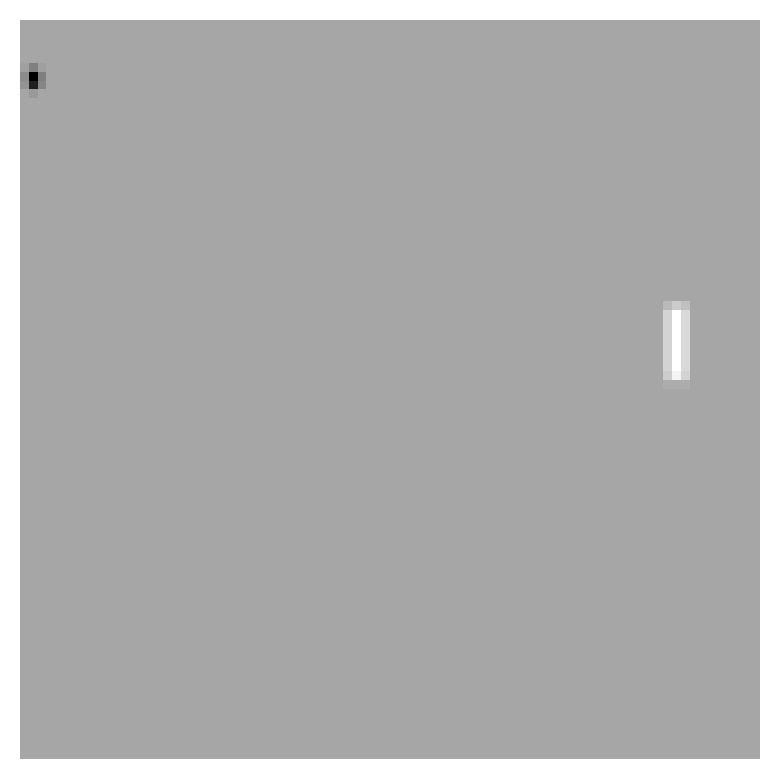

In [7]:
if type(env) == ALEEnvironment:
  width = env.env.getScreenDims()[1]
  height =  env.env.getScreenDims()[0]
  env.crop = (0, 34, width, height - 16)

  plt.imshow(env.get_frame(), cmap='gray')
  plt.axis('off')
  plt.show()

# Deep Q-Network (DQN)

Define ALE DQN

In [8]:
class ALEDQN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(env.num_channels, 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
    self.fc1 = nn.Linear(64*7*7, 512)
    self.fc2 = nn.Linear(512, env.num_actions)

  def forward(self, x):
    # 3x84x84
    x = F.relu(self.conv1(x))
    
    # 32x20x20
    x = F.relu(self.conv2(x))

    # 64x9x9
    x = F.relu(self.conv3(x))

    # 64x7x7
    x = F.relu(self.fc1(x.flatten(start_dim=1)))
    x = self.fc2(x)

    return x

Define MinAtar DQN

In [9]:
class MinAtarDQN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(env.num_channels, 32, 3, padding='same')
    self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
    self.fc1 = nn.Linear(64*2*2, 512)
    self.fc2 = nn.Linear(512, env.num_actions)
    self.maxpool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    # 4x10x10
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    
    # 32x5x5
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)

    # 64x2x2
    x = F.relu(self.fc1(x.flatten(start_dim=1)))
    x = self.fc2(x)

    return x

Select DQN

In [10]:
dqn_class = ALEDQN if type(env) == ALEEnvironment else MinAtarDQN
summary(dqn_class(), input_shape=env.state_shape)

Layer (type:depth-idx)                   Param #
ALEDQN                                   --
├─Conv2d: 1-1                            4,128
├─Conv2d: 1-2                            32,832
├─Conv2d: 1-3                            36,928
├─Linear: 1-4                            1,606,144
├─Linear: 1-5                            3,078
Total params: 1,683,110
Trainable params: 1,683,110
Non-trainable params: 0

# Training

Define training functions

In [11]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
  def __init__(self, size):
    self.memory = deque([], maxlen=size)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

def train_dqn():
  global dqn, dqn_target, optimizer, replay_memory, batch_size

  if len(replay_memory) < batch_size:
    return

  # get batch of transitions from replay memory
  transitions = replay_memory.sample(batch_size)
  transition_batch = Transition(*zip(*transitions))

  # get next states that are not final states
  non_final_indices = torch.tensor([next_state is not None for next_state in transition_batch.next_state])
  non_final_next_states = torch.cat([next_state for next_state in transition_batch.next_state if next_state is not None])

  # separate transitions batch by state, action, reward
  state_batch = torch.cat(transition_batch.state)
  action_batch = torch.cat(transition_batch.action)
  reward_batch = torch.cat(transition_batch.reward)
  reward_batch[~non_final_indices] = -1.0

  # get current q values and calculate expected q values
  q_values = dqn(state_batch).gather(1, action_batch)
  next_q_values = torch.zeros(batch_size, device=device)
  next_q_values[non_final_indices] = dqn_target(non_final_next_states).max(1)[0].detach()
  expected_q_values = (next_q_values * gamma) + reward_batch

  # calculate loss
  loss = criterion(q_values, expected_q_values.unsqueeze(1))

  # update network
  optimizer.zero_grad()
  loss.backward()
  for param in dqn.parameters():
    param.grad.data.clamp_(-1, 1)
  optimizer.step()

def select_action(state):
  global epsilon, epsilon_start, epsilon_end, epsilon_random_frames, epsilon_greedy_frames, steps, dqn
  steps += 1
  if steps >= epsilon_random_frames:
    epsilon -= (epsilon_start - epsilon_end) / epsilon_greedy_frames
    epsilon = max(epsilon, epsilon_end)
  if steps < epsilon_random_frames or epsilon > random.random():
    return torch.tensor([[random.randrange(env.num_actions)]], device=device, dtype=torch.long)
  else:
     with torch.no_grad():
      return dqn(state).max(1)[1].view(1, 1)

def plot_stats():
  global epsilon, episode_rewards, steps
  
  display.clear_output(wait=True)
  
  plt.title('Episode Total Rewards')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, 'o', markersize=2)
  plt.show()
  
  print(f'Total Episodes: {len(episode_rewards)} | Total Steps: {steps} | Max Score: {max(episode_rewards)} | Epsilon: {epsilon}')

Training settings

In [19]:
max_score = 21
batch_size = 32
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.005
epsilon_random_frames = 50000
epsilon_greedy_frames = 1000000
replay_memory_size = 100000
frame_skip = 8
steps_per_target_update = 10000
steps_per_dqn_update = 4
steps_per_plot_update = 10

Train dqn

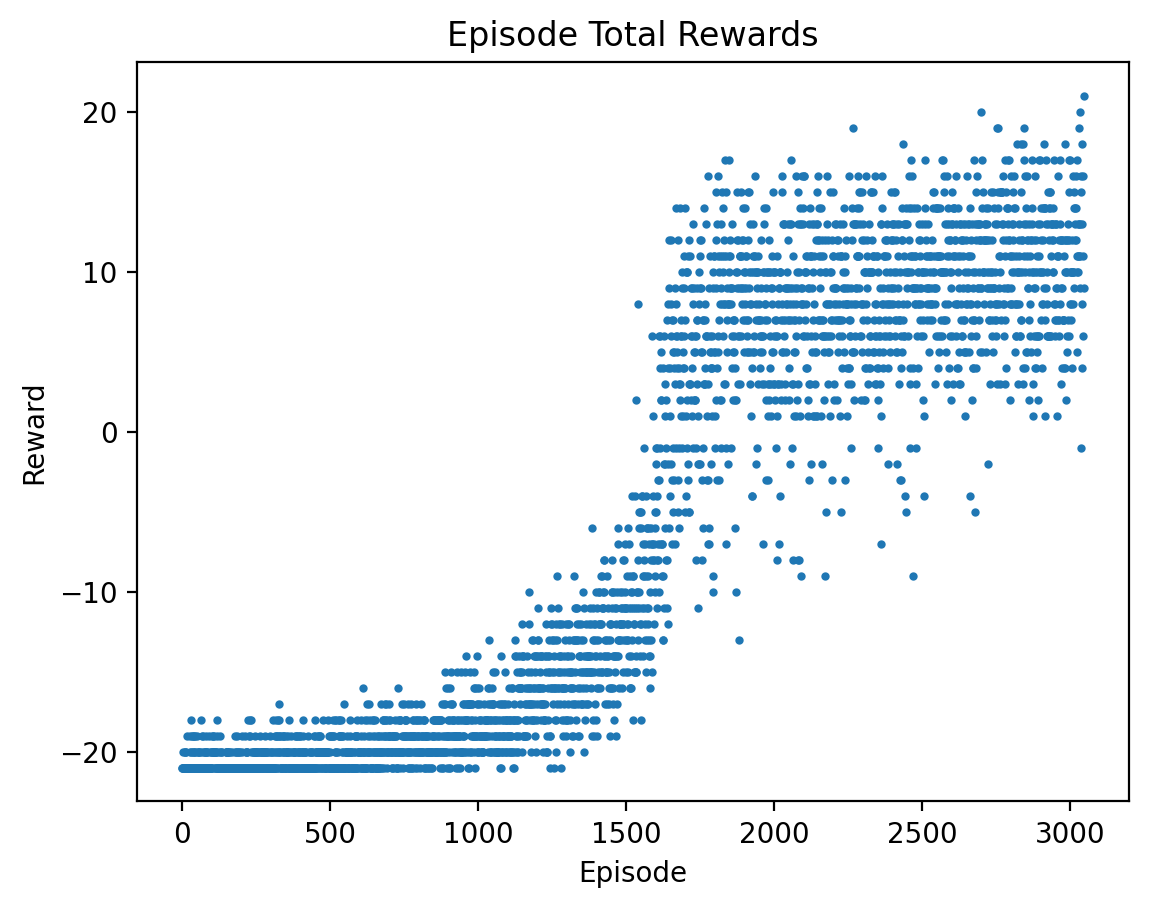

Total Episodes: 3046 | Total Steps: 3189807 | Max Score: 21 | Epsilon: 0.005


In [20]:
# initialize dqn and target dqn
dqn = dqn_class().to(device)
dqn_target = dqn_class().to(device)
dqn_target.load_state_dict(dqn.state_dict())

# initialize replay memory and training loss and optimizer
replay_memory = ReplayMemory(replay_memory_size)
criterion = nn.HuberLoss()
optimizer = Adam(dqn.parameters(), lr=0.00025)

steps = 0
epsilon = epsilon_start
episode_rewards = []

for episode in count():
  state = env.reset()
  total_reward = 0

  for t in count():

    # select action using epsilon greedy strategy
    action = select_action(state)

    # perform action and get reward
    next_state, reward, done = env.step(action, frame_skip)
    total_reward += reward

    # add to replay memory
    next_state = None if done else next_state
    reward = torch.tensor([reward], device=device)
    replay_memory.push(state, action, next_state, reward)
    state = next_state

    # train dqn on data saved to replay memory
    if steps % steps_per_dqn_update == 0:
      train_dqn()

    # update target dqn with weights from main dqn
    if steps % steps_per_plot_update == 0:
      dqn_target.load_state_dict(dqn.state_dict())
    
    # check if game is over
    if done:
      episode_rewards.append(total_reward)
      if episode % steps_per_plot_update == 0:
        plot_stats()
      break

  # stop training once max score is reached
  if total_reward >= max_score:
    plot_stats()
    break

Save trained agent

In [21]:
torch.save(dqn.state_dict(), 'saved_models/pong_dqn.pt')
torch.save(dqn_target.state_dict(), 'saved_models/pong_dqn_target.pt')

# Results

Load trained agent

In [ ]:
dqn = dqn_class(env).to(device)
dqn_target = dqn_class(env).to(device)

dqn.load_state_dict(torch.load('saved_models/pong_dqn.pt'))
dqn_target.load_state_dict(torch.load('saved_models/pong_dqn_target.pt'))

Run game with trained agent

In [29]:
final_score = 21

total_reward = 0
while total_reward < final_score:
  total_reward = 0
  state = env.reset()
  frames = [env.render()]

  for t in count():
    action = torch.argmax(dqn(state))
    state, reward, done = env.step(action, frame_skip)
    if reward == -1:
      done = True
    total_reward += reward
    
    frames.append(env.render())
    
    if done or total_reward >= final_score:
      break

Visualize gameplay

In [30]:
fig, ax = plt.subplots()
fig.tight_layout(pad=0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

def get_frame(index):
  ax.clear()
  return ax.imshow(frames[index], aspect=env.aspect, cmap=env.cmap)

plt.close()
gameplay = animation.FuncAnimation(fig, get_frame, frames=len(frames), interval=50)
gameplay

Save gameplay as gif

In [32]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.10.23+dfsg-2.1ubuntu11.4).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [34]:
gameplay.save('pong.gif', writer='imagemagick', fps=30)